In [ ]:
#Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For normalizing and PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For data train-test split
from sklearn.model_selection import train_test_split

# For ML modeling
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import ConfusionMatrixDisplay

import random
from random import randint
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read a csv file
df = pd.read_csv("https://raw.githubusercontent.com/Rashmi-PP/DS5010_project/main/Taiwandata.csv")
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065200e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361300e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [ ]:
# Show info of the dataset, number of non-null values, datatype of each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
df.shape

(6819, 96)

In [ ]:
# Check for null values explicitly
df.isnull().sum().sort_values(ascending=False).head() #sort sum of null values for each column in descending order


 Equity to Liability                 0
 Net Income Flag                     0
 Operating Profit Growth Rate        0
 After-tax Net Profit Growth Rate    0
 Regular Net Profit Growth Rate      0
dtype: int64

In [ ]:
# Check if all records of every feature has same value
def unique_cols(df):
    a = df.to_numpy() 
    return (a[0] == a).all(0)

unique_cols(df)
# array([False, False])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False])

In [ ]:
#Drop the column as it has same value throughout the dataset 
df.drop([' Net Income Flag'],axis=1, inplace=True)
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.127236,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065200e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361300e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207

In [ ]:
(pd.DataFrame(df.dtypes)).value_counts() #get count of columns of each datatype

float64    93
int64       2
dtype: int64

In [ ]:
#Separating numerical and categorical features
numeric_features = df.dtypes[df.dtypes != 'int64'].index # numeric features are of type float64
categorical_features = df.dtypes[df.dtypes == 'int64'].index # categorical features are of type int64

# List the categorical features
df[categorical_features].columns.tolist()

['Bankrupt?', ' Liability-Assets Flag']

In [ ]:
# Check unique cvalues of the variable
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

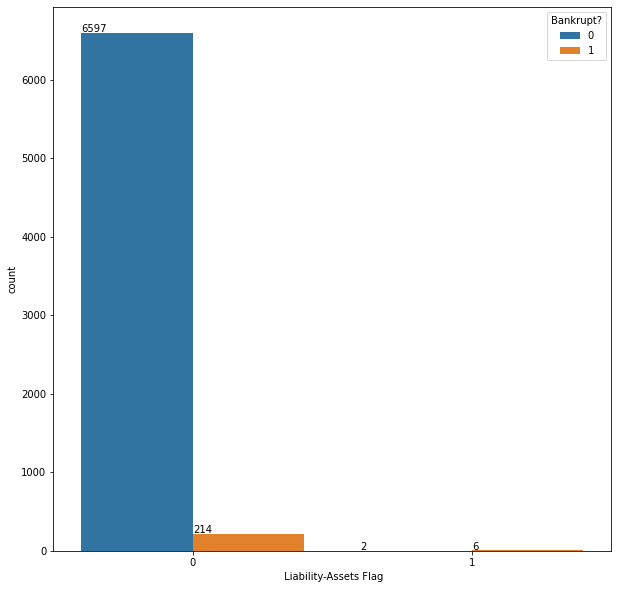

In [ ]:
# Bar plot of count of records with 1/0 Liability assets flag
plt.figure(figsize =(10, 10))

ax=sns.countplot(data= df, x=' Liability-Assets Flag', hue = 'Bankrupt?')
for p in ax.patches: #patches is the area behind each bar
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0, p.get_height()+10)) #second argument is the location of the annotation
plt.show()

In [ ]:
# Train test split dataframe
X = df.iloc[:,1:95]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_test.shape

(1364, 94)

In [ ]:
# Training data x and y combined
X_y_train = pd.concat([X_train,pd.DataFrame(y_train)],axis=1)

0    5281
1     174
Name: Bankrupt?, dtype: int64


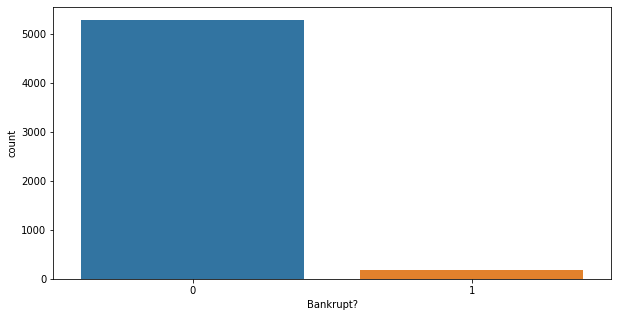

In [ ]:
# Check count of target variable in the training dataset by plotting a bar graph for the same
plt.figure(figsize =(10, 5))
sns.countplot('Bankrupt?',data=X_y_train)
print(X_y_train['Bankrupt?'].value_counts())
plt.show()

The data for each class label is highly biased. Records for non-bankruptcy cases are seen to be high.

In [ ]:
X_train.describe() #show statistics of each feature

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5.455000e+03,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000
mean,0.504749,0.558201,0.553187,0.607820,0.607803,0.998693,0.797126,0.809022,0.303641,0.781323,1.979058e+09,1.977986e+09,0.467252,1.583355e+07,0.115028,0.190413,0.190395,0.190433,0.228594,0.323335,1.660862e+06,0.108757,0.184200,0.022434,0.847951,0.689074,0.689087,0.217663,5.531443e+09,1.710357e+06,0.264259,0.379502,5.041247e+05,7.567369e+06,0.631008,3.797434e+06,0.113876,0.886124,0.008949,0.374717,...,0.399063,0.521031,0.123244,3.109074e+06,3.144711e+07,0.091197,0.353420,0.277235,5.574896e+07,0.761562,0.735682,0.331489,5.749287e+07,0.934678,0.002585,0.029095,1.183733e+09,2.172506e+09,0.594014,2.481238e+09,0.671518,1.525206e+06,0.761562,0.331489,0.115622,0.649363,0.461535,0.592741,0.315534,0.031694,0.000917,0.807596,2.151971e+07,0.623921,0.607818,0.840407,0.280427,0.027533,0.565373

As this column has does not vary throughout the dataset, it can be ignored (not useful for data modeling/prediction).

## Normalizing data

In [ ]:
# Balancing dataset by undersampling
X_y_train = pd.concat([X_train,pd.DataFrame(y_train)],axis=1)

df_bankrupt1 = X_y_train[X_y_train['Bankrupt?']==1]
df_bankrupt0 = X_y_train[X_y_train['Bankrupt?']==0]
df_bankrupt0 = df_bankrupt0.iloc[0:df_bankrupt1.shape[0],:] #sample for bankruptcy=0 as many as bankruptcy=1
df_sampled = pd.concat([df_bankrupt0,df_bankrupt1])
X_y_train = df_sampled.sample(frac=1).reset_index(drop=True) # frac=1 returns all rows after shuffling; drop=True doesn't retain old index values of rows
X_y_train.head()


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.430556,0.470508,0.472027,0.595267,0.595267,0.998923,0.797263,0.809196,0.303400,0.781445,7.300000e+09,7.130000e+08,0.461537,0.000332,0.000000,0.152459,0.152459,0.152459,0.189468,0.317960,0.046947,0.086882,0.150109,0.021985,0.847802,0.687583,0.687583,0.217390,4.910000e+09,0.000374,0.263011,0.376979,0.006107,0.004404,0.630260,0.018944,0.200139,0.799861,0.005137,0.382649,...,0.654182,0.039400,0.005166,0.001060,0.197148,0.341082,0.280145,0.002787,0.943567,0.732521,0.342119,0.001357,0.910057,0.002056,0.041534,1.029550e-04,9.310000e+09,0.593917,1.830000e+09,0.671568,0.239701,0.943567,0.342119,0.113492,0.631152,0.457763,0.567370,0.311202,0.047094,0,0.753568,0.001865,0.623464,0.595262,0.834026,0.288518,0.026691,0.564629,0.017228,1
1,0.483157,0.548354,0.537127,0.625074,0.624454,0.999059,0.797442,0.809364,0.303428,0.781627,4.049590e-04,4.860000e+08,0.464498,0.000552,0.024395,0.170452,0.170452,0.170452,0.217926,0.322240,0.012584,0.100969,0.173834,0.022119,0.848032,0.689437,0.689437,0.217584,8.820000e+09,0.000711,0.263955,0.382447,0.008306,0.003936,0.632459,0.006475,0.122623,0.877377,0.005216,0.374804,...,0.383837,0.047353,0.004743,0.002895,0.086516,0.346903,0.277758,0.009550,0.663970,0.733990,0.330080,0.008317,0.930413,0.002261,0.035048,2.265920e-04,1.345660e-04,0.593960,7.600000e+08,0.671576,0.390737,0.663970,0.330080,0.116105,0.646093,0.459928,0.589539,0.315070,0.034991,0,0.802265,0.000768,0.623680,0.625071,0.840540,0.279475,0.027410,0.567020,0.030427,1
2,0.201969,0.200720,0.228652,0.590914,0.590914,0.998625,0.796846,0.808804,0.303294,0.781065,3.006550e-04,5.860000e+09,0.452396,0.000280,0.000000,0.142598,0.142598,0.142598,0.122341,0.305935,0.041381,0.030535,0.090382,0.021885,0.846452,0.685863,0.685863,0.217219,2.620000e+09,0.000265,0.260623,0.333911,0.009239,0.005659,0.6

In [ ]:
# Dataframe for Xtrain and ytrain after cleanup and balancing samples for both classes of bankruptcy
X_train = X_y_train.iloc[:,0:94]
y_train = X_y_train.iloc[:,94]

In [ ]:
normalized_X_train=(X_train-X_train.min())/(X_train.max()-X_train.min()) #min max standardization
normalized_X_train.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.654674,0.651642,0.651631,0.485932,0.485932,0.883143,0.885285,0.886295,0.888376,0.880675,7.403651e-01,7.187500e-02,0.587053,3.388092e-13,0.000000,0.246983,0.246983,0.246983,0.415061,0.684395,0.149178,0.390128,0.411917,0.096473,0.970454,0.962556,0.948773,0.891375,0.501020,4.009014e-14,0.766484,0.836499,0.036730,4.771737e-13,0.366268,0.018766,0.374076,0.625924,0.000718,0.163442,...,0.620785,0.649841,0.047230,0.032526,1.064794e-13,0.565586,0.558732,0.728881,3.170794e-13,0.940623,0.887693,0.133166,1.938566e-13,0.756347,0.179725,0.086287,2.319235e-16,9.319319e-01,0.137668,1.886598e-01,0.700124,2.840698e-11,0.940623,0.133166,0.123076,0.577371,0.632520,0.643032,0.641169,0.099043,0.0,0.718242,1.889274e-13,0.787154,0.485901,0.834026,0.129376,0.013368,0.436973,0.031038
1,0.739434,0.759456,0.748369,0.718201,0.713371,0.907679,0.889245,0.890232,0.888740,0.884810,3.090284e-14,4.899194e-02,0.601819,5.633214e-13,0.025008,0.300654,0.300654,0.300654,0.522484,0.712620,0.039668,0.453382,0.513925,0.098601,0.972458,0.974242,0.960291,0.905900,0.900000,7.619507e-14,0.830013,0.849523,0.050767,4.264148e-13,0.373931,0.006294,0.224911,0.775089,0.000804,0.152811,...,0.234946,0.372456,0.056809,0.029790,3.100871e-13,0.236394,0.569064,0.679716,1.086485e-12,0.646439,0.889473,0.117303,1.188170e-12,0.841476,0.213710,0.072242,1.268278e-14,3.447447e-15,0.145888,7.835052e-02,0.703615,4.656031e-11,0.646439,0.117303,0.125910,0.595983,0.636088,0.684918,0.649138,0.072677,0.0,0.820585,6.930851e-14,0.787427,0.718190,0.840540,0.118310,0.014990,0.458365,0.061882
2,0.286332,0.277992,0.289976,0.452013,0.452013,0.829663,0.876073,0.877079,0.886996,0.872028,2.032434e-14,5.907258e-01,0.541469,2.857429e-13,0.000000,0.217572,0.217572,0.217572,0.161670,0.605085,0.131441,0.137112,0.155117,0.094881,0.9

In [ ]:
# Normalize test data with parameters obtained on training data
normalized_X_test = (X_test-X_train.min())/(X_train.max()-X_train.min()) #min max normalization
normalized_X_test.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
4929,0.736292,0.650132,0.712729,0.496939,0.496939,0.876156,0.882667,0.882560,0.886741,0.879931,3.471400e-15,0.485887,0.612728,4.020806e-13,0.000000,0.266717,0.266717,0.266717,0.481442,0.699090,0.034077,0.409872,0.457578,0.096737,0.970065,0.953839,0.940180,0.861701,0.467347,4.340139e-14,0.757909,0.845707,0.053142,5.802459e-13,0.366690,0.003021,0.136308,0.863692,0.000976,0.149945,...,0.217239,0.294510,0.131463,0.036391,9.493837e-13,0.177451,0.580866,0.675093,8.964407e-13,0.797877,0.888737,0.115298,6.936229e-13,0.764737,0.166945,0.060109,1.840886e-15,8.298298e-01,0.142568,2.123918e-15,0.704292,4.048521e-11,0.797877,0.115298,0.122390,0.600070,0.638452,0.699766,0.649775,0.069494,0.0,0.716216,4.631336e-13,0.787707,0.496922,0.837323,0.115406,0.013408,0.437894,0.108177
6424,0.769521,0.772669,0.771519,0.629135,0.629135,0.908843,0.889701,0.890612,0.889033,0.885342,1.265436e-14,0.287298,0.592550,0.000000e+00,0.062571,0.342132,0.342132,0.342132,0.548894,0.694658,0.086567,0.487386,0.532060,0.097903,0.972570,0.973197,0.959261,0.905612,0.744898,4.848585e-14,0.801098,0.834347,0.092657,1.033629e-12,0.367497,0.004512,0.181860,0.818140,0.005117,0.145809,...,0.968417,0.841021,0.133173,0.095880,5.994821e-13,0.296077,0.564647,0.663663,1.646212e-14,1.000000,0.897316,0.117774,0.000000e+00,0.883623,0.219754,0.079699,1.656405e-14,1.826727e-14,0.158659,9.793814e-02,0.705424,4.651971e-12,1.000000,0.117774,0.120301,0.607336,0.640085,0.661118,0.651673,0.039426,0.0,0.839162,1.650611e-14,0.788141,0.629122,0.841104,0.116729,0.013594,0.441713,0.079298
3807,0.794894,0.744432,0.782180,0.509968,0.509968,0.893789,0.888526,0.889390,0.890101,0.883935,6.430020e-01,0.355847,0.655334,2.847224e-13,0.246031,0.318376,0.318376,0.318376,0.516060,0.727782,0.053164,0.434735,0.504858,0.096613,0.9716

**Normalized data:**
*Training*: normalized_X_train;
*Testing*: normalized_X_test

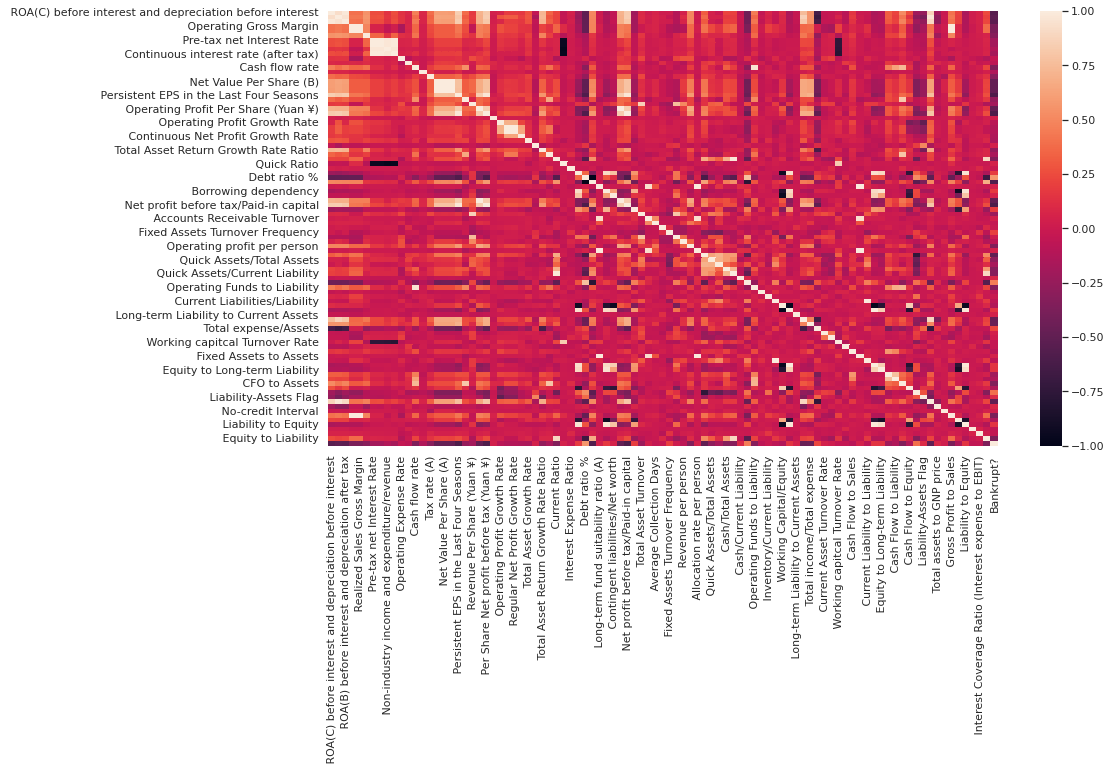

In [ ]:
# Correlation with all features
correlation_ = pd.concat([normalized_X_train,pd.DataFrame(y_train)],axis = 1).corr(method = 'pearson')
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(correlation_,annot=False)


In [ ]:
# Obtain top 5 positively and negatively correlated features each

positive_corr = normalized_X_train.corrwith(X_y_train['Bankrupt?']).sort_values(ascending=False)[:5]
print("Positively correalted\n",positive_corr)

negative_corr = normalized_X_train.corrwith(X_y_train['Bankrupt?']).sort_values()[:5]
print("\nNegatively correalted\n",negative_corr)


Positively correalted
  Debt ratio %                           0.577263
 Current Liability to Assets            0.459397
 Current Liability to Current Assets    0.395949
 Total expense/Assets                   0.230433
 Fixed Assets Turnover Frequency        0.196617
dtype: float64

Negatively correalted
  Persistent EPS in the Last Four Seasons                   -0.593509
 Per Share Net profit before tax (Yuan ¥)                  -0.590243
 Net profit before tax/Paid-in capital                     -0.586549
 Net worth/Assets                                          -0.577263
 ROA(C) before interest and depreciation before interest   -0.543558
dtype: float64


---------------------------------------------------------------
*   Debt ratio% - percentage of a company's assets that are provided via debt
*   Current Liability to Current Assets - calculated for the upcoming year

    A current asset is any asset that will provide an economic value for or within one year.
*   Fixed assets turnover freq - sales/value of fixed assets
*   Earnings per share (EPS) is the portion of a company's profit allocated to each outstanding share
*   Return on assets - net income/total assets
------------------------------------------


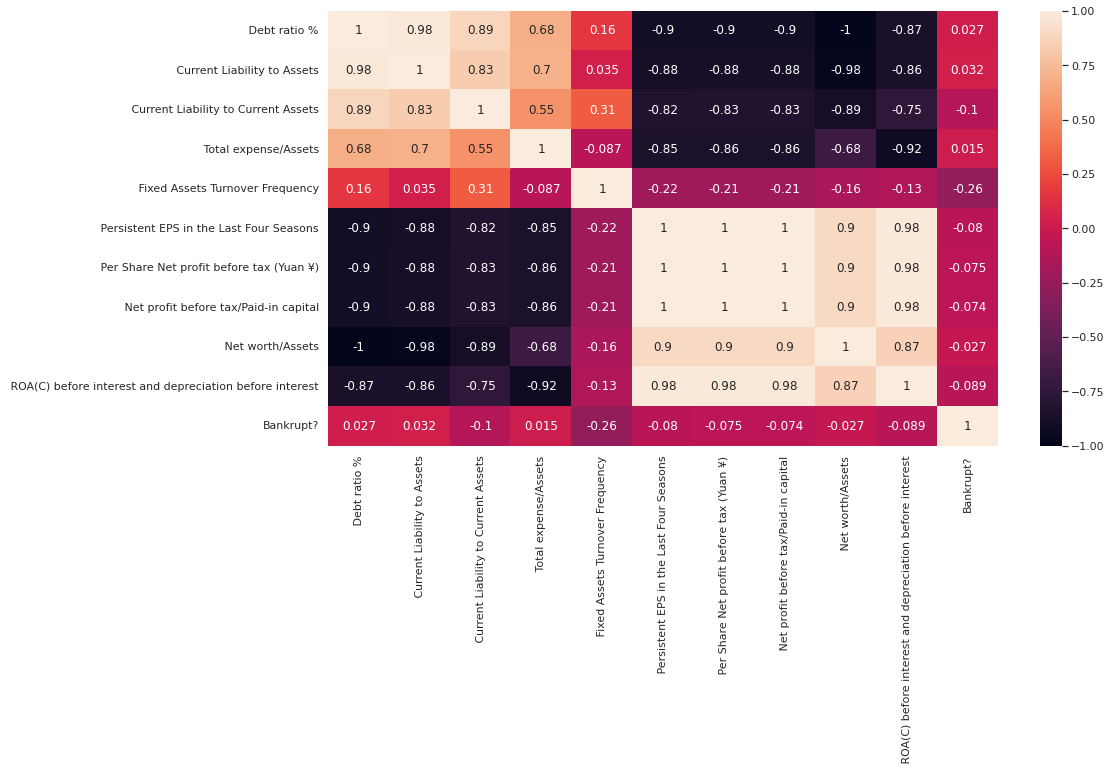

In [ ]:
# Plot heat map of correlation data
new_df_corr = normalized_X_train[positive_corr.index.tolist() + negative_corr.index.tolist()] #to get both positive and negatively correlated features
new_df_corr['Bankrupt?'] = df['Bankrupt?']
correlation = new_df_corr.corr()
# corr.style.background_gradient(cmap='PuBu_r')
sns.heatmap(correlation.corr(),annot=True)



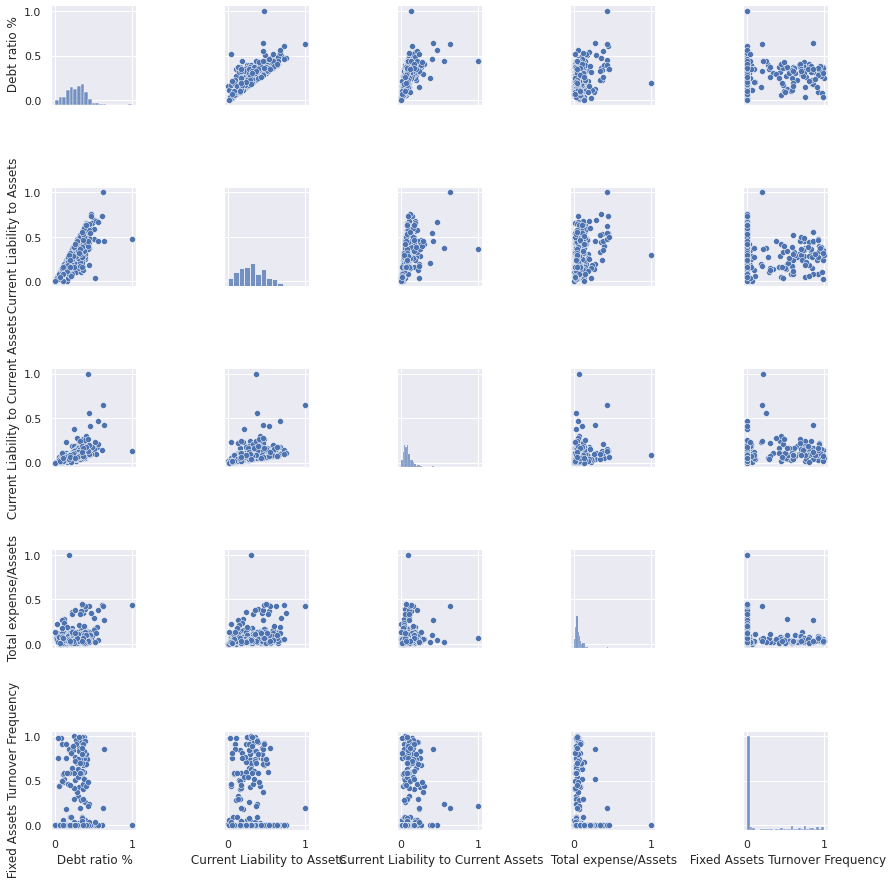

In [ ]:
## Observe the correlation among positively correlated features
new_df_corr1 = normalized_X_train[positive_corr.index.tolist()] #to get both positive and negatively correlated features
sns.pairplot(new_df_corr1)

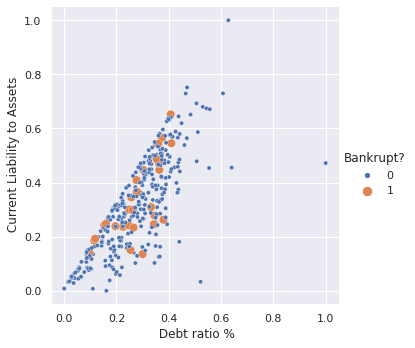

In [ ]:
# Variation of top 2 positively correlated features and bankruptcy status
sns.set(rc = {'figure.figsize':(20,10)})
sns.relplot(x = ' Debt ratio %', y = ' Current Liability to Assets', hue = 'Bankrupt?',
            data = new_df_corr, size='Bankrupt?', size_order = [1,0]) #Fixed assets turnover freq -> sales/value of fixed assets


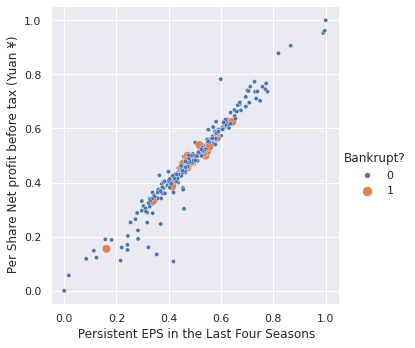

In [ ]:
# Variation of top 2 negatively correlated features and bankruptcy status - Note that the two features are positively correlated among themselves
sns.set(rc = {'figure.figsize':(20,10)})
sns.relplot(x = ' Persistent EPS in the Last Four Seasons', y = ' Per Share Net profit before tax (Yuan ¥)', hue = 'Bankrupt?',
            data = new_df_corr, size='Bankrupt?', size_order = [1,0]) #Fixed assets turnover freq -> sales/value of fixed assets


In [ ]:
# Obtain bargraphs for seeing ratio of records with baknruptcy status for positively correlated data
def corrbargraph(x_value, y_value):
  
    plt.figure(figsize=(15,10))

    for i in range(1,6):
        plt.subplot(2,3,i)  
        sns.barplot(x = x_value, y = y_value[i-1],data = positive_corr_)
#         plt.bar(df, y_value, width=0.8, bottom=None, align='center')

    plt.tight_layout(pad=0.5)

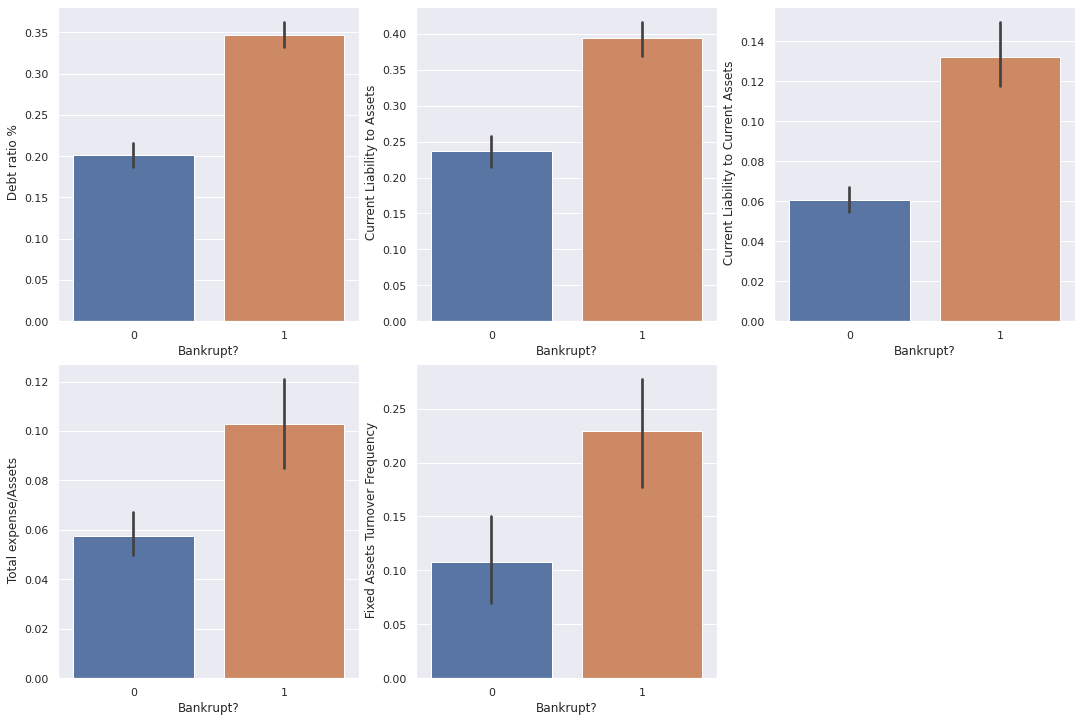

In [ ]:
positive_corr_ = normalized_X_train[positive_corr.index.tolist()]
positive_corr_['Bankrupt?'] = X_y_train["Bankrupt?"].copy()


x_value = positive_corr_.columns.to_list()[-1]
y_value = positive_corr_.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

In [ ]:
# Obtain bargraphs for seeing ratio of records with baknruptcy status for negatively correlated data
def corrbargraph(x_value, y_value):
  
    plt.figure(figsize=(15,10))

    for i in range(1,6):
        plt.subplot(2,3,i)  
        sns.barplot(x = x_value, y = y_value[i-1],data = negative_corr_)

    plt.tight_layout(pad=0.5)

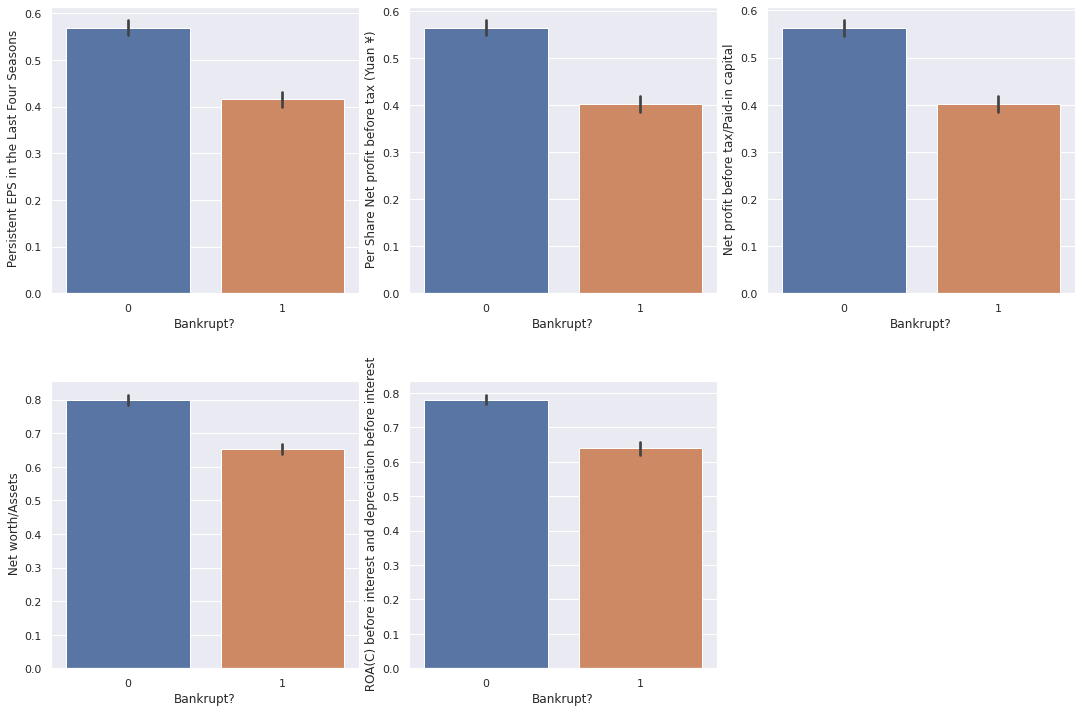

In [ ]:
negative_corr_ = normalized_X_train[negative_corr.index.tolist()]
negative_corr_['Bankrupt?'] = X_y_train["Bankrupt?"].copy()

x_value = negative_corr_.columns.to_list()[-1]
y_value = negative_corr_.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

###Feature selection using logistic regression with L1 penalty

In [ ]:
#LR with L1/lasso penalty makes coefficients of some of the features zero
sel = SelectFromModel(LogisticRegression(C=1, penalty='l1',solver='liblinear')) 
sel.fit(normalized_X_train, y_train)
selected=sel.get_support()
selected

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
        True, False, False, False,  True, False, False, False,  True,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False])

In [ ]:
# List the features selected
list1 = []
for i in range(len(selected)):
    if(selected[i]==True):
       print("selected feature",X_train.columns[i])
       list1.append(normalized_X_train.columns[i])
    else:
      #  print("Feature not selected",df.columns[i])
        pass
print(list1)

selected feature  ROA(C) before interest and depreciation before interest
selected feature  Research and development expense rate
selected feature  Persistent EPS in the Last Four Seasons
selected feature  Per Share Net profit before tax (Yuan ¥)
selected feature  Regular Net Profit Growth Rate
selected feature  Debt ratio %
selected feature  Total Asset Turnover
selected feature  Fixed Assets Turnover Frequency
selected feature  Quick Assets/Total Assets
selected feature  Current Assets/Total Assets
selected feature  Current Liability to Assets
selected feature  Current Liabilities/Liability
selected feature  Retained Earnings to Total Assets
selected feature  Quick Asset Turnover Rate
selected feature  Cash Turnover Rate
selected feature  Current Liability to Liability
selected feature  No-credit Interval
[' ROA(C) before interest and depreciation before interest', ' Research and development expense rate', ' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax 

In [ ]:
# Training data with the reduced feature set
normalized_X_train[list1].head()


,ROA(C) before interest and depreciation before interest,Research and development expense rate,Persistent EPS in the Last Four Seasons,Per Share Net profit before tax (Yuan ¥),Regular Net Profit Growth Rate,Debt ratio %,Total Asset Turnover,Fixed Assets Turnover Frequency,Quick Assets/Total Assets,Current Assets/Total Assets,Current Liability to Assets,Current Liabilities/Liability,Retained Earnings to Total Assets,Quick Asset Turnover Rate,Cash Turnover Rate,Current Liability to Liability,No-credit Interval
0,0.654674,7.187500e-02,0.415061,0.411917,0.948773,0.374076,0.249104,3.733273e-14,0.620785,0.649841,0.565586,0.940623,0.756347,9.319319e-01,1.886598e-01,0.940623,0.787154
1,0.739434,4.899194e-02,0.522484,0.513925,0.960291,0.224911,0.089606,6.815816e-16,0.234946,0.372456,0.236394,0.646439,0.841476,3.447447e-15,7.835052e-02,0.646439,0.787427
2,0.286332,5.907258e-01,0.161670,0.155117,0.938091,0.363779,0.281362,1.003363e-13,0.566596,0.778062,0.447262,0.759026,0.455801,5.485485e-02,2.144330e-01,0.759026,0.787499
3,0.736606,1.023508e-14,0.471092,0.454663,0.957445,0.300192,0.053763,3.333333e-01,0.096775,0.146861,0.135835,0.265301,0.839379,0.000000e+00,4.355361e-15,0.265301,0.787661
4,0.758523,3.165323e-01,0.559243,0.542422,0.961144,0.153354,0.209677,7.693714e-14,0.491114,0.432423,0.241980,0.964514,0.900938,9.389389e-01,8.340206e-01,0.964514,0.787893


#Principal Component Analysis (PCA)

In [ ]:
# Standardize the data (using parameters mean and std. deviation)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test) # uses parameters(mean and variance) obtained from fitting training data 

In [ ]:
# Peform PCA
pca = PCA(n_components = 10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
#Display explained variance of each component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.19464078, 0.09206755, 0.06328711, 0.05565928, 0.05211678,
       0.04565526, 0.03750872, 0.03403485, 0.02743669, 0.02469211])

In [ ]:
#Training data with PCA components
principal_df_y = pd.concat([pd.DataFrame(X_train_pca),pd.DataFrame(y_train)], axis=1)
principal_df_y.head()

,0,1,2,3,4,5,6,7,8,9,Bankrupt?
0,2.551521,0.012978,-0.613480,-1.791775,1.494402,-1.000286,-0.334032,-1.103262,-0.108956,-0.957545,1
1,-1.496651,-0.169204,0.184816,1.160247,-0.990703,0.707634,-0.260567,-0.552734,1.729433,-0.573514,1
2,9.205388,-2.458000,1.671094,-4.018663,-1.477881,-0.048984,0.881974,-2.287909,-0.464685,1.747207,1
3,0.694923,-0.505291,-1.851215,3.252056,-1.714558,0.821047,0.623198,0.841278,-1.164033,1.354576,1
4,-1.911185,0.335734,-0.791654,-0.679908,0.820487,-0.813301,0.508783,-0.231308,0.162123,0.046792,0


# Machine learning model

## Logistic Regression


In [ ]:
# With all features
model = LogisticRegression(solver='liblinear', penalty='l1')
model.fit(normalized_X_train, y_train)
yhat = model.predict(normalized_X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, yhat)
print('Test Accuracy:', acc)


Test Accuracy: 0.8695014662756598


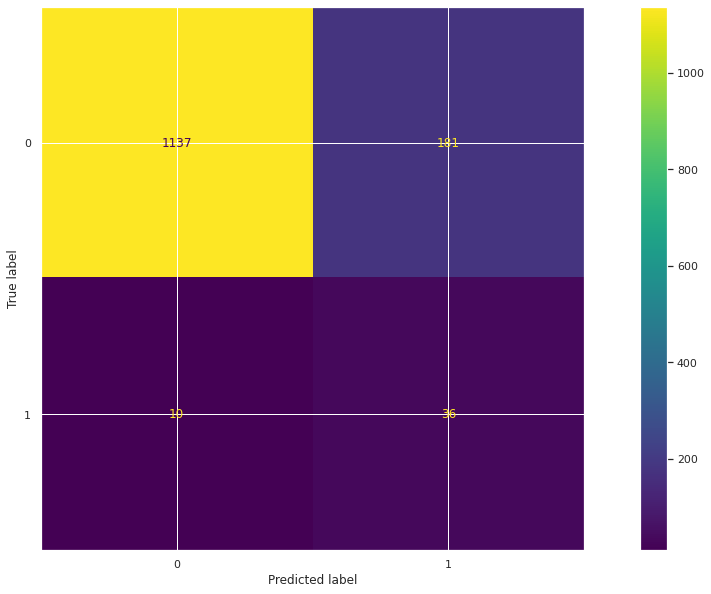

In [ ]:
ConfusionMatrixDisplay.from_estimator(model.fit(normalized_X_train, y_train), normalized_X_test, y_test )

Test Accuracy: 0.8687683284457478


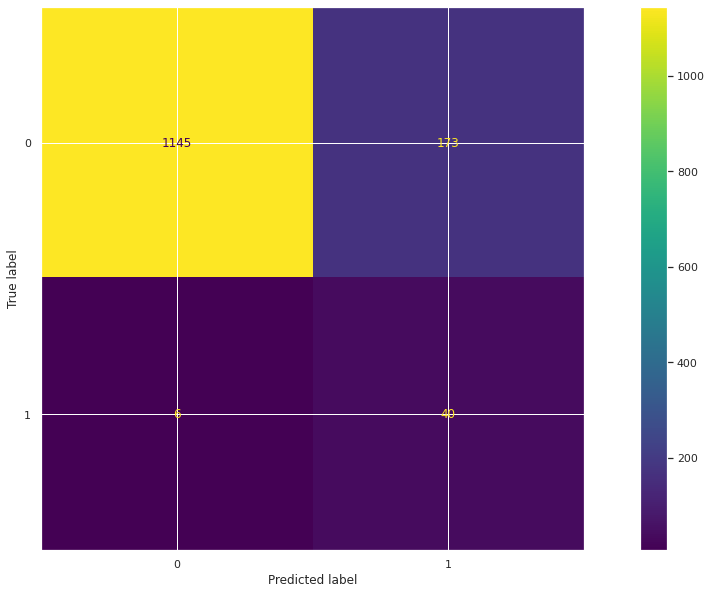

In [ ]:
#With features obtained after lasso feature selection
model = LogisticRegression(solver='liblinear', penalty='l1')
model.fit(normalized_X_train[list1], y_train)
yhat = model.predict(normalized_X_test[list1])

acc = accuracy_score(y_test, yhat)
print('Test Accuracy:', acc)
ConfusionMatrixDisplay.from_estimator(model.fit(normalized_X_train[list1], y_train), normalized_X_test[list1], y_test)

Test Accuracy: 0.8541055718475073


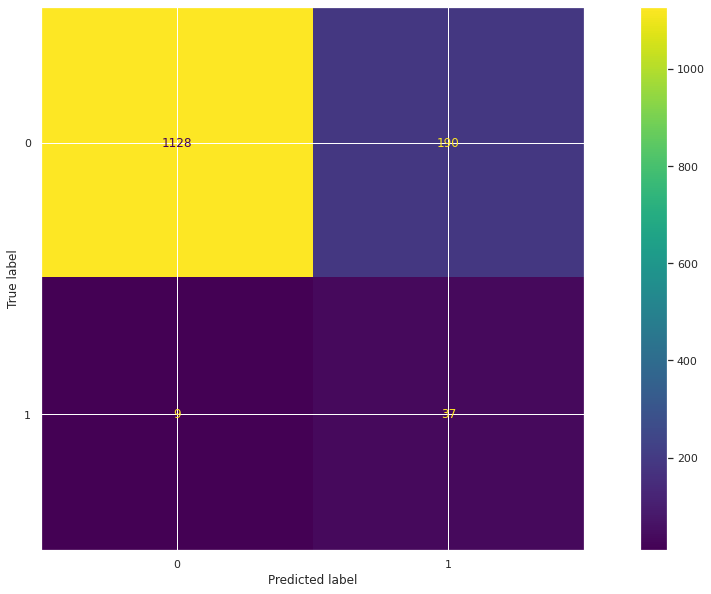

In [ ]:
# Logistic regression with PCA features
model = LogisticRegression(solver='liblinear', penalty='l1')
model.fit(X_train_pca, y_train)
yhat = model.predict(X_test_pca)

acc = accuracy_score(y_test, yhat)
print('Test Accuracy:', acc)
ConfusionMatrixDisplay.from_estimator(model.fit(X_train_pca, y_train), X_test_pca, y_test)